# Import Required Libraries
Import the necessary libraries, including GeoPandas, Shapely, and Pandas.

In [1]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import numpy as np
import geopandas as gpd
from pathlib import Path

from PIL import Image
import matplotlib.pyplot as plt

data_path = Path('London_UK')

# Load data
panoids = gpd.read_file(data_path / 'panoids/panoids.geojson')
network = gpd.read_file(data_path / 'network/edges/edges.geojson')

# Load Street Network Data
Load the street network data from a GeoJSON file or other data source.

In [2]:
# Load Street Network Data
streets = network  # Replace with your data source

# Load Image GPS Coordinates
Create a DataFrame with image IDs and their corresponding GPS coordinates.

In [3]:
# Load Image GPS Coordinates
# Create a DataFrame with image IDs and their corresponding GPS coordinates

image_data = {
    'image_id': np.linspace(0, len(panoids) - 1, len(panoids)),
    'longitude': panoids.lng,
    'latitude': panoids.lat,
}
images_df = pd.DataFrame(image_data)

# Create GeoDataFrame for images
geometry = [Point(xy) for xy in zip(images_df['longitude'], images_df['latitude'])]
images_gdf = gpd.GeoDataFrame(images_df, geometry=geometry, crs=streets.crs)

# Create GeoDataFrame for Images
Convert the DataFrame to a GeoDataFrame with Point geometries and set the coordinate reference system (CRS).

In [4]:
# Create GeoDataFrame for Images
geometry = [Point(xy) for xy in zip(images_df['longitude'], images_df['latitude'])]
images_gdf = gpd.GeoDataFrame(images_df, geometry=geometry, crs=streets.crs)

# Perform Spatial Join
Use the sjoin_nearest function to find the nearest street for each image and add the distance information.

In [5]:
# Perform Spatial Join
matched = gpd.sjoin_nearest(images_gdf, streets, how='left', distance_col='distance')

# Now 'matched' contains street information for each image
matched[['image_id', 'longitude', 'latitude', 'distance'][:5][0:2]]
matched_first_row = matched.iloc[[8]]

print(matched_first_row[['image_id', 'longitude', 'latitude', 'distance']])


   image_id  longitude   latitude  distance
8       8.0  -0.111446  51.510339  0.000574


/Users/tangshiya/anaconda3/envs/DSAIE/lib/python3.9/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [6]:
def get_image_id_by_coords(lat, lon):
    # Find the row in the matched DataFrame that matches the given coordinates
    row = matched[(matched['latitude'] == lat) & (matched['longitude'] == lon)]
    
    if not row.empty:
        return row['image_id'].values[0]
    else:
        return None

# Example usage
latitude = 51.51033857385067  # Replace with the desired latitude
longitude = -0.1114464626242011  # Replace with the desired longitude
image_id = get_image_id_by_coords(latitude, longitude)

if image_id is not None:
    print(f"Image ID for coordinates ({latitude}, {longitude}): {image_id}")
else:
    print(f"No image found for coordinates ({latitude}, {longitude})")

Image ID for coordinates (51.51033857385067, -0.1114464626242011): 8.0


# Display Matched Results
Print or visualize the matched results, including image IDs and distances to the nearest streets.

      image_id      distance
0          0.0  4.727227e-04
1          1.0  4.652413e-04
2          2.0  4.817731e-04
3          3.0  1.958920e-05
4          4.0  3.804349e-06
...        ...           ...
9008    9008.0  9.611725e-06
9009    9009.0  7.151419e-06
9010    9010.0  3.945103e-06
9011    9011.0  4.789095e-07
9012    9012.0  5.151160e-06

[9135 rows x 2 columns]


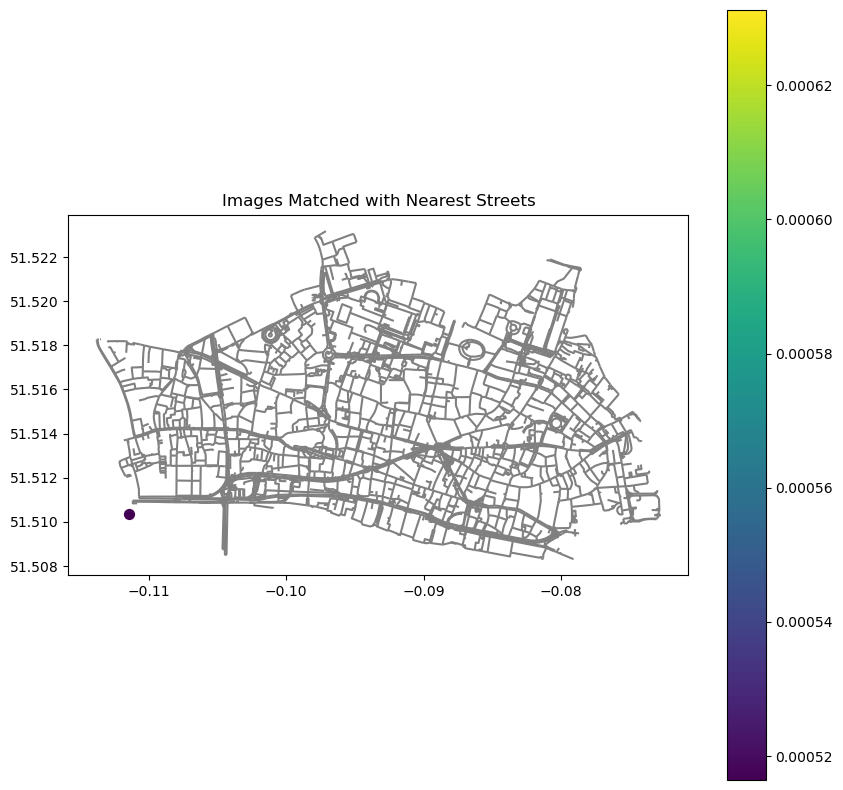

In [7]:
# Display Matched Results

# Print the matched results, including image IDs and distances to the nearest streets
print(matched[['image_id', 'distance']])

# Optionally, visualize the matched results on a map
import matplotlib.pyplot as plt

# Plot the streets
base = streets.plot(color='gray', figsize=(10, 10))

# Plot the images with distances
matched_first_row.plot(ax=base, column='distance', legend=True, cmap='viridis', markersize=50)

plt.title('Images Matched with Nearest Streets')
plt.show()

/Users/tangshiya/anaconda3/envs/DSAIE/lib/python3.9/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


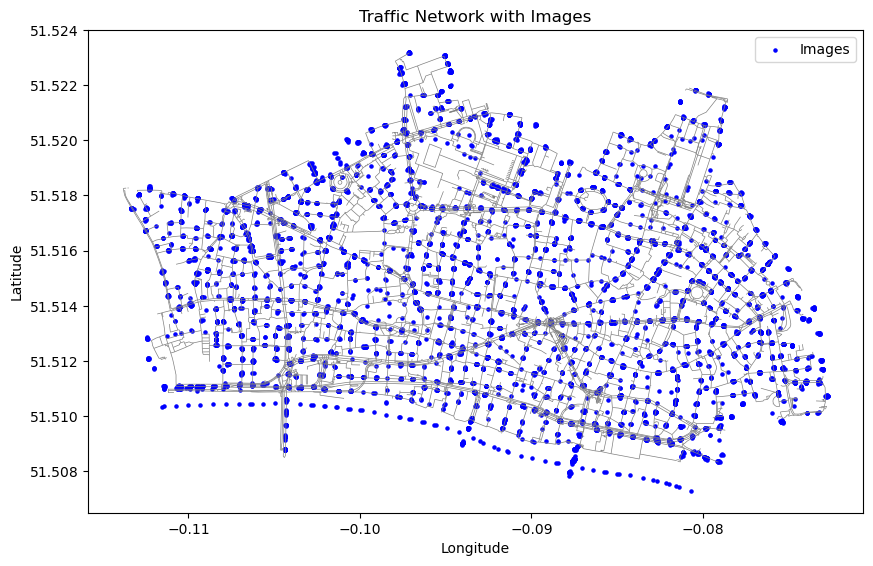

In [8]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import matplotlib.pyplot as plt

# Load street network data
# streets = gpd.read_file('streets.geojson')  # Replace with your data source

# Assuming panoids DataFrame has columns 'panoid', 'lng', and 'lat'
# Example:
# panoids = pd.DataFrame({
#     'panoid': ['id1', 'id2', 'id3', ...],
#     'lng': [-0.10543, -0.0949, -0.10601, ...],
#     'lat': [51.51575, 51.51736, 51.51575, ...]
# })

# Create a DataFrame with image IDs and their corresponding GPS coordinates
image_data = {
    'image_id': np.arange(len(panoids)),
    'panoid': panoids.panoid,
    'longitude': panoids.lng,
    'latitude': panoids.lat,
}
images_df = pd.DataFrame(image_data)

# Create GeoDataFrame for images
geometry = [Point(xy) for xy in zip(images_df['longitude'], images_df['latitude'])]
images_gdf = gpd.GeoDataFrame(images_df, geometry=geometry, crs=streets.crs)

# Perform Spatial Join to find nearest street for each image
matched = gpd.sjoin_nearest(images_gdf, streets, how='left', distance_col='distance')
# Function to get coordinates by image ID
def get_coords_by_image_id(image_id):
    row = matched[matched['image_id'] == image_id]
    if not row.empty:
        return row['geometry'].values[0].x, row['geometry'].values[0].y
    else:
        return None, None

# Visualize the traffic network with images
fig, ax = plt.subplots(figsize=(10, 10))
streets.plot(ax=ax, color='gray', linewidth=0.5)
images_gdf.plot(ax=ax, color='blue', markersize=5, label='Images')

# Add labels and legend
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Traffic Network with Images')
plt.legend()

plt.show()

## Images to vector embeddings

In [19]:
import torch
from torchvision import models, transforms
from PIL import Image
import os

# Set a seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [20]:
# Function to load an image and transform it
def load_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Function to get embeddings from a model
def get_embeddings(model, image_path):
    image = load_image(image_path)
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No need to track gradients
        embeddings = model(image)
    return embeddings


In [21]:
vgg = models.vgg16(pretrained=True)
vgg.classifier[6] = torch.nn.Identity()  # Modify the last layer

/Users/tangshiya/anaconda3/envs/DSAIE/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/tangshiya/anaconda3/envs/DSAIE/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
# Example usage
image_path = '/Users/tangshiya/DSAIE/STREET/London_UK/imagedb/image_0_f.png'
vgg_embeddings = get_embeddings(vgg, image_path)

print("VGG Embeddings:", vgg_embeddings.shape)
print(vgg_embeddings)

VGG Embeddings: torch.Size([1, 4096])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.8926, 0.0000]])


In [31]:
# convert the images within the folder
# Path to the image folder
image_folder = '/Users/tangshiya/DSAIE/STREET/London_UK/imagedb'
image_files = os.listdir(image_folder)
image_files.sort()  # Ensure file order if necessary

# Process the first 100 images
embeddings_list = []
for file_name in image_files[:1000]:
    file_path = os.path.join(image_folder, file_name)
    embeddings = get_embeddings(vgg, file_path)
    embeddings_list.append(embeddings)
    print(f"Processed {file_name}")


Processed image_0_b.png
Processed image_0_f.png
Processed image_0_s_a.png
Processed image_0_s_b.png
Processed image_1000_b.png
Processed image_1000_f.png
Processed image_1000_s_a.png
Processed image_1000_s_b.png
Processed image_1001_b.png
Processed image_1001_f.png
Processed image_1001_s_a.png
Processed image_1001_s_b.png
Processed image_1002_b.png
Processed image_1002_f.png
Processed image_1002_s_a.png
Processed image_1002_s_b.png
Processed image_1003_b.png
Processed image_1003_f.png
Processed image_1003_s_a.png
Processed image_1003_s_b.png
Processed image_1004_b.png
Processed image_1004_f.png
Processed image_1004_s_a.png
Processed image_1004_s_b.png
Processed image_1005_b.png
Processed image_1005_f.png
Processed image_1005_s_a.png
Processed image_1005_s_b.png
Processed image_1007_b.png
Processed image_1007_f.png
Processed image_1007_s_a.png
Processed image_1007_s_b.png
Processed image_1008_b.png
Processed image_1008_f.png
Processed image_1008_s_a.png
Processed image_1008_s_b.png
Proc

## Clustering with dimensionality reduction

/Users/tangshiya/anaconda3/envs/DSAIE/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


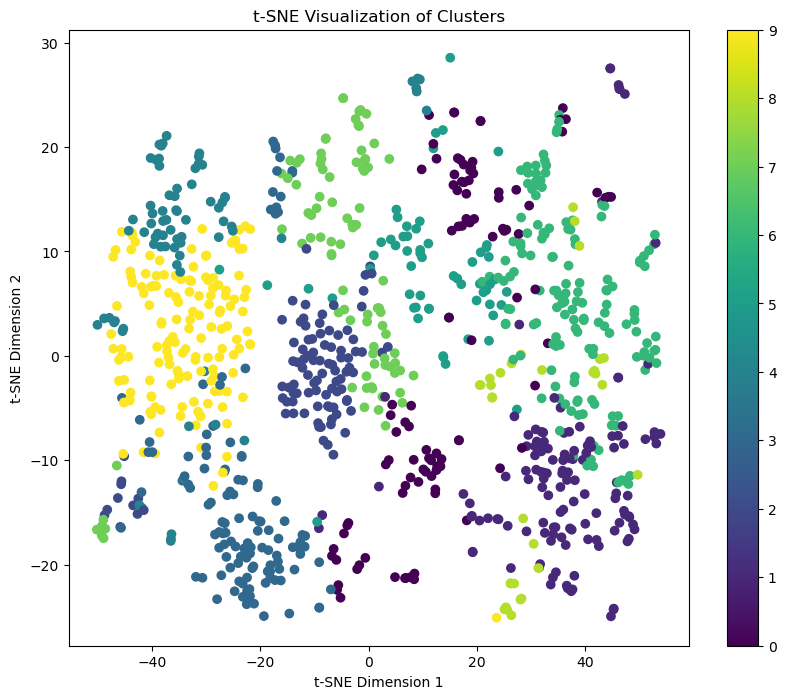

In [51]:
## 1. clustering: k-means
# dimensionality reduction: t-SNE visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

embeddings_np = np.array([emb.squeeze().numpy().flatten() for emb in embeddings_list])
# Now, embeddings_np should be a 2D array where each row represents an image embedding
# Proceed with clustering
kmeans = KMeans(n_clusters=10, random_state=42)
#kmeans.fit(embeddings_np)
labels = kmeans.fit_predict(embeddings_np)

tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings_np)

# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels, cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


In [52]:
print(len(labels))

1000


## visualize the clustering result, to know each clustering present what category(put a label?)

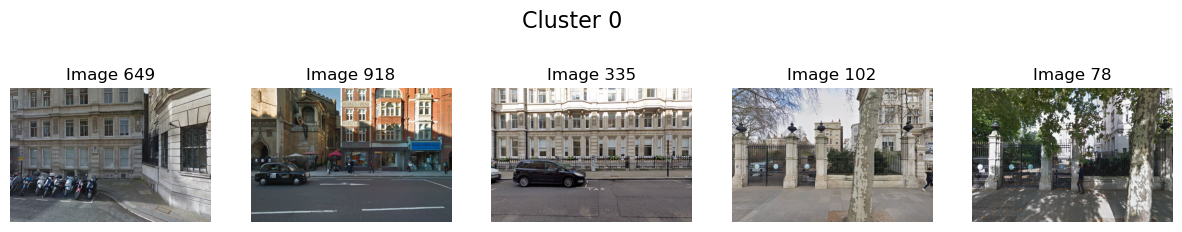

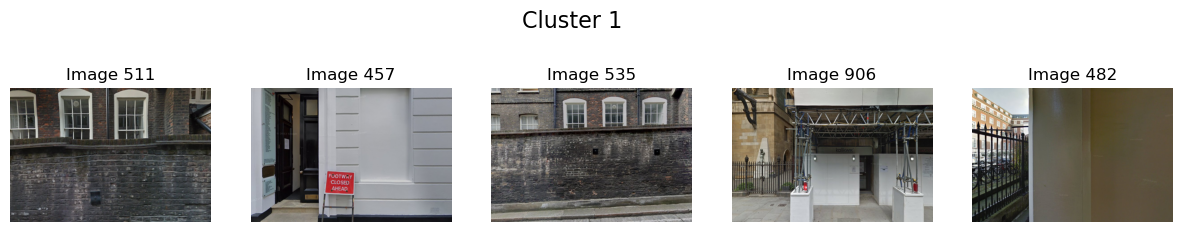

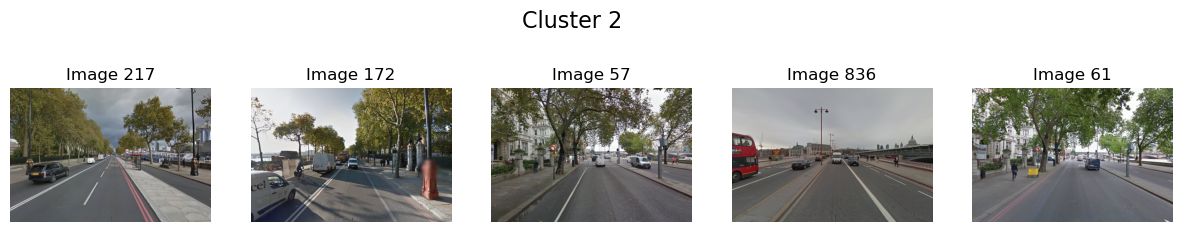

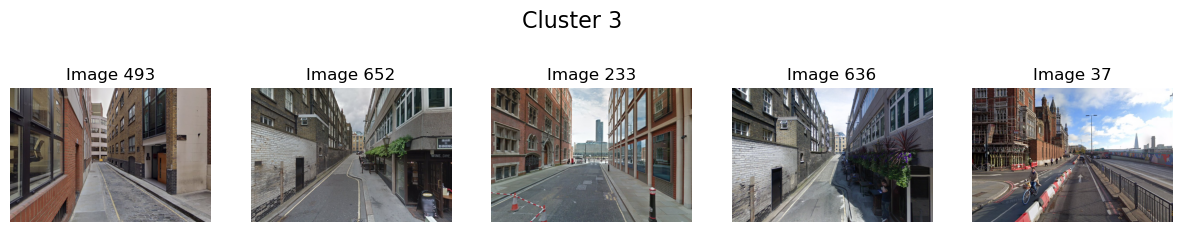

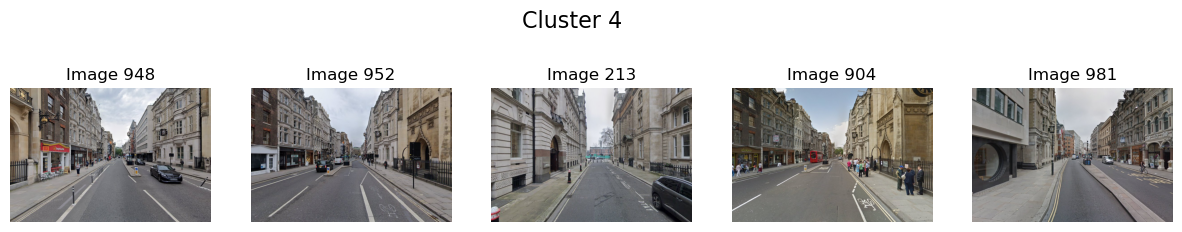

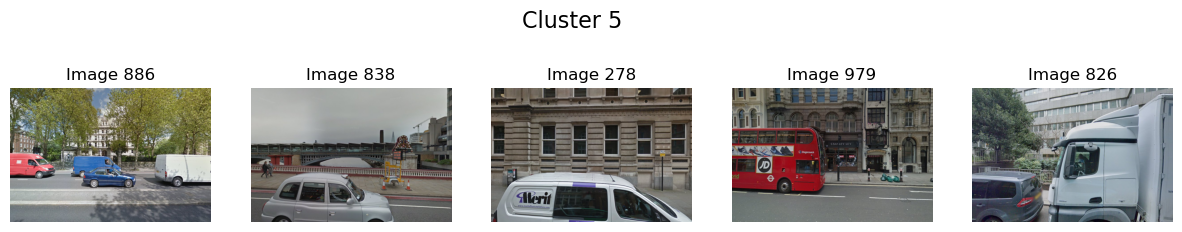

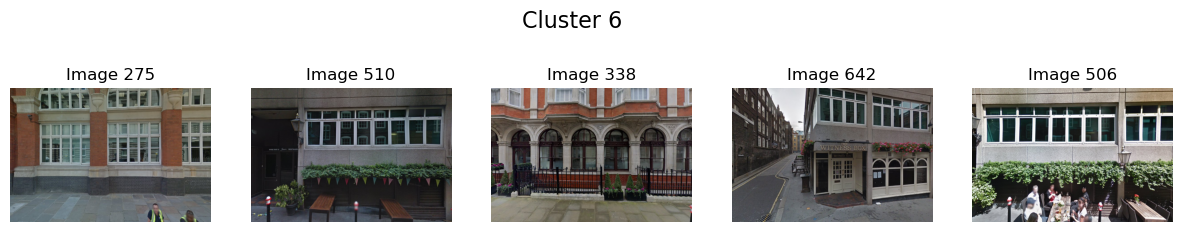

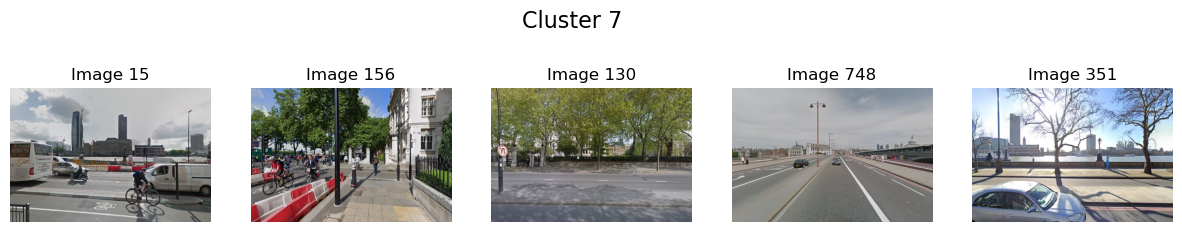

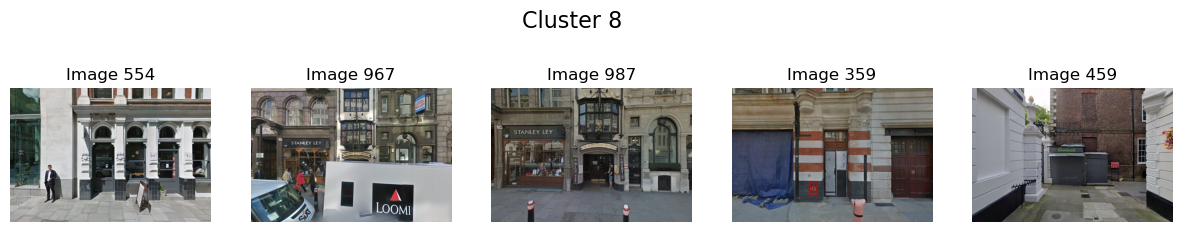

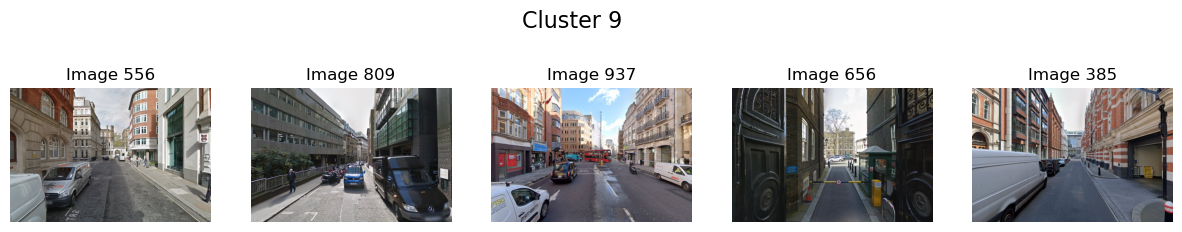

In [53]:
def display_images_from_cluster(labels, image_folder, num_clusters, num_images=5):
    # Create a figure with subplots
    for cluster_id in range(num_clusters):
        cluster_indices = np.where(labels == cluster_id)[0]
        if len(cluster_indices) > num_images:
            selected_indices = np.random.choice(cluster_indices, num_images, replace=False)
        else:
            selected_indices = cluster_indices
        
        if len(selected_indices) == 0:
            print(f"No images to display for cluster {cluster_id}")
            continue  # Skip this iteration if no images are in the cluster

        # Handling case when there is one image to display properly
        fig, axs = plt.subplots(1, max(len(selected_indices), 1), figsize=(15, 3))  # Ensure at least one subplot
        fig.suptitle(f'Cluster {cluster_id}', fontsize=16)

        if len(selected_indices) == 1:  # If there's only one image, axs is not a list
            axs = [axs]

        for i, idx in enumerate(selected_indices):
            img_path = os.path.join(image_folder, image_files[idx])
            img = Image.open(img_path)
            axs[i].imshow(img)
            axs[i].axis('off')
            axs[i].set_title(f'Image {idx}')

        plt.show()

display_images_from_cluster(labels, image_folder, num_clusters=10, num_images=5)
